# Projeto: Análise de Anomalias em Série Temporal

BIMASTER - Trabalho de final de curso

Nome: Alex Marques Campos

Etapa 02.B: Detecção de anomalias via predição de séries

O objetivo deste notebook é carregar os dados das séries históricas de interesse e observar se é possível utilizar predição de séries temporais para realizar a detecção de anomalias. Para isso, um modelo LSTM.

O primeiro passo é carregar as bibliotecas necessárias ao processamento e os dados propriamente ditos, que estão armazenados nos arquivos CSV (_comma separated values_) armazenados no subdiretório './__dados__/'.

## Configuração do ambiente de execução

In [1]:
import math
import matplotlib
import random

import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from pathlib import Path
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Dropout
from tensorflow.keras.models import Sequential
from typing import Dict, Tuple

In [2]:
NOME_DIRETORIO_DADOS = 'dados'
NOME_DIRETORIO_MODELOS = 'modelos'
NOME_ARQUIVO_SERIE_IBCBR = 'serie_ibcbr.csv'

In [3]:
# ajustamos o formato de apresentação padrão dos gráficos
sns.set_theme(style="white", palette="pastel")

In [4]:
# habilitamos a visualização especial de dataframes disponível no
# Google Colaboratory, para facilitar a exploração dos dados.
from google.colab import data_table
data_table.enable_dataframe_formatter()

## Informações do ambiente de execução

In [5]:
print(f'pandas == {pd.__version__}')
print(f'matplotlib == {matplotlib.__version__}')
print(f'tensorflow == {tf.__version__}')

pandas == 1.3.5
matplotlib == 3.2.2
tensorflow == 2.9.2


In [6]:
!cat /etc/os-release

NAME="Ubuntu"
VERSION="20.04.5 LTS (Focal Fossa)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 20.04.5 LTS"
VERSION_ID="20.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=focal
UBUNTU_CODENAME=focal


In [7]:
!uname -a

Linux 6d000caa61a3 5.10.147+ #1 SMP Sat Dec 10 16:00:40 UTC 2022 x86_64 x86_64 x86_64 GNU/Linux


In [8]:
print(f'CPU count: {multiprocessing.cpu_count()}')

CPU count: 2


In [9]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Carga dos dados

Lembre-se de criar uma pasta chamada '/content/dados' no Google Colaboratory e enviar os arquivos '.csv' para essa pasta.

In [10]:
path_dir_dados = Path('.') / NOME_DIRETORIO_DADOS
path_arq_ibcbr = path_dir_dados / NOME_ARQUIVO_SERIE_IBCBR

In [11]:
def carregar_csv(path_csv:Path) -> pd.DataFrame:
  """
  Carrega os dados de um arquivo CSV em um dataframe de
  forma padronizada no escopo do projeto.
  path_csv : objeto Path que aponta para o arquivo.
  """
  if (path_csv is None) or (not path_csv.is_file()):
    raise ValueError("The given path object doesn't point to a valid csv file.")

  return pd.read_csv(path_csv,
                   sep=',',
                   parse_dates=True,
                   infer_datetime_format=True,
                   index_col=0,
                   decimal='.',
                   encoding='utf8')

In [12]:
# carregamos o arquivo de dado em um dataframe, para iniciar a análise
df_ibcbr = carregar_csv(path_arq_ibcbr)

In [13]:
def verificar_propriedades(id:int, nome:str, dataframe:pd.DataFrame) -> None:
  """
  Imprime propriedades do dataframe nomeado para inspeção visual dos dados.
  id: inteiro que identifica o dataframe.
  nome: nome do dataframe
  dataframe: objeto do dataframe
  """
  print(f'[{id:03d}] Dataframe: {nome}')
  print('-' * 5)
  print(f'Shape: {dataframe.shape}')
  print('-' * 5)
  print(dataframe.head(4))
  print('')

In [14]:
# verificamos se os dataframes foram carregados corretamente.
series = {
  'IBC-BR': df_ibcbr
}

for idx,serie in enumerate(series.items()):
  verificar_propriedades(idx+1, serie[0], serie[1])

[001] Dataframe: IBC-BR
-----
Shape: (236, 1)
-----
             valor
data              
2003-01-01   96.15
2003-02-01   98.67
2003-03-01  103.41
2003-04-01  102.19



Neste ponto, temos todos os dados carregados em DataFrames pandas e prontos para análise.

## Predição de Série Temporal

### Definição de funções auxiliares

Começamos definindo funções auxiliares ao processo de análise.

In [15]:
def montar_treino_teste_validacao_por_janela(dataset:np.array, 
                                             window_size:int=24,
                                             test_size:float=0.15,
                                             val_size:float=0.15,
                                             random_state:int=None
                                             ) -> Tuple[np.array, np.array, np.array, np.array, np.array, np.array]:
    """
    Recebe um dataframe e o divide em conjuntos de treino, validação e teste
    com janelas (dos conjuntos X) de tamanho definido.
    
    Parâmetros:
    dataset      : Numpy array a ser dividido em treino, validação e teste.
    window_size  : Tamanho da janela deslizante a ser aplicada ao dataset e também
                   o tamanho de cada elemento dos conjuntos X.
    test_size    : float entre 0.01 e 1.00, que representa o valor percentual do 
                   conjunto de teste com relação ao tamanho do dataset.
    val_size     : float entre 0.01 e 1.00, que representa o valor percentual do 
                   conjunto de validação com relação ao tamanho do dataset.
    random_state : inteiro que representa o estado randômico da execução do passo
                   da escolha dos elementos de treino e teste.

    Nota: test_size + val_size deve ser um valor menor do que 1.00, pois deve
          existir um conjunto de treino.

    Retorna: X_train, y_train, X_val, y_val, X_test e y_test, onde cada elemento
             é um array numpy.
    """
    data_size = len(dataset)
    X = []
    y = []

    if data_size < (window_size + 1):
      raise ValueError("""
      The input data dimension 0's length should be at least window_size + 1.
      """)

    if test_size < 0.01 or test_size > 1.00:
      raise ValueError('The value of test_size should be between 0.01 and 1.00')

    if val_size < 0.01 or val_size > 1.00:
      raise ValueError('The value of val_size should be between 0.01 and 1.00')
    
    if test_size + val_size >= 1.00:
      raise ValueError('test_size + val_size should be less than 1.00')

    for i in range(window_size, data_size):
        X.append(dataset[i-window_size:i])
        y.append(dataset[i])
    X, y = np.array(X), np.array(y)

    # na primeira chamada, dividimos o conjunto em treino e teste,
    # onde o tamanho do conjunto de teste é explícito (default de 15%) e 
    # o tamanho do conjunto de treino fica proporcional a (1 - test_size) 
    # (default de 85%).
    X_train_tmp, X_test, y_train_tmp, y_test = train_test_split(X, 
                                                                y, 
                                                                test_size=test_size,
                                                                random_state=random_state)

    # para obter o conjunto de validação, dividimos novamente o conjunto de 
    # treino, cujo tamanho agora é diretamente proprorcional a (1 - test_size),
    # em duas partes, mas agora o conjunto de teste será nossa 'validação'.

    # como val_size é referente a 100% e o conjunto agora é menor,
    # recalculamos val_size para o tamanho atual do conjunto de treinamento
    # antes de o dividir novamente.
    val_size_recalculado = val_size / (1 - test_size)
    
    # dividimos novamente o conjunto, agora em treino e validação
    # desabilitamos o shuffle porque ele é desnecessário.
    # passamos o random_state só por completude (como shuffle está desabilitado
    # esse argumento não deveria ter efeito na chamada).
    X_train, X_val, y_train, y_val = train_test_split(X_train_tmp, 
                                                      y_train_tmp, 
                                                      test_size=val_size_recalculado,
                                                      shuffle=False,
                                                      random_state=random_state)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
def imprimir_propriedades_aux(a_var:np.array, a_name:str) -> None:
  print(f'Tamanho de {a_name} = {len(a_var)}')
  if type(a_var[0]) == np.float64:
    tam_elem = 1
  else:
    tam_elem = len(a_var[0])
  print(f'   Tamanho de um elemento de {a_name} = {tam_elem}')

In [17]:
def imprimir_propriedades(X_train, y_train, X_val, y_val, X_test, y_test) -> None:
  imprimir_propriedades_aux(X_train, 'X_train')
  imprimir_propriedades_aux(y_train, 'y_train')
  imprimir_propriedades_aux(X_val, 'X_val')
  imprimir_propriedades_aux(y_val, 'y_val')
  imprimir_propriedades_aux(X_test, 'X_test')
  imprimir_propriedades_aux(y_test, 'y_test')

In [18]:
def create_model(optimizer:str = 'sgd',
                 lstm_layer_size:int = 240,
                 input_shape:Tuple[int,int] = (24, 1),
                 add_extra_layer:bool = False) -> tf.keras.models.Sequential:
    '''
    Cria um modelo de rede neural a ser treinado, usando os parâmetros:
    optimizer       : string com o nome do otimizador a ser usado para compilar
                      o modelo.
    lstm_layer_size : número de neurônios na(s) camada(s) LSTM da rede neural.
    input_shape     : tupla que indica tamanho dos dados de entrada da rede.
    add_extra_layer : booleano que indica se uma camada extra LSTM deve ou não
                      ser adicionada ao modelo (a camada extra tem 1/4 das 
                      unidades da camada LSTM principal, com um mínimo de 12 
                      unidades garantidas).
    retorna o modelo criado.
    '''
    # se fomos solicitados a prover uma camada extra, precisamos
    # retornar as sequências após a primeira LSTM
    return_sequences = add_extra_layer

    model = Sequential()
    model.add(LSTM(lstm_layer_size,
                   input_shape=input_shape,
                   return_sequences=return_sequences))
    model.add(Dropout(0.2))
    if (add_extra_layer):
        model.add(LSTM(
              max(int(lstm_layer_size / 4), 12)
            )
        )
        model.add(Dropout(0.2))
    model.add(Dense(24, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.summary()

    return model

In [19]:
def train_model(model:tf.keras.models.Sequential, 
                X_train:np.array,
                y_train:np.array,
                X_val:np.array,
                y_val:np.array,
                X_test:np.array, 
                y_test:np.array, 
                checkpoint_path:str = None, 
                batch_size:int = 20,
                n_epochs:int = 240) -> object:
    '''
    Treina o modelo 'model' com os dados de '[Xy]_train' (treinamento), '[Xy]_val' 
    (validação) e '[Xy]_test' (teste). Caso um path seja fornecido na variável 
    'checkpoint_path', salva neste path os melhores modelos encontrados durante 
    o treinamento.
    Retorna o objeto de história do treinamento.
    '''
    # callbacks para modificar o processo de treinamento
    callbacks = []
    callbacks.append(ReduceLROnPlateau(patience=15, factor=0.5, verbose=True))
    if not checkpoint_path is None:
      callbacks.append(ModelCheckpoint(checkpoint_path, save_best_only=True))
    callbacks.append(EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=25,
                            verbose=1,
                            mode='min'))
    
    history = model.fit(x=X_train,
                        y=y_train,
                        validation_data=(X_val, y_val),
                        batch_size=batch_size,
                        epochs=n_epochs,
                        shuffle=False,
                        callbacks=callbacks)

    return history

In [20]:
def plot_train_results(history:object):
  df_history = pd.DataFrame(history.history)
  ax = df_history[['val_loss', 'loss']].plot(figsize=(10, 5))
  df_history['lr'].plot(ax=ax.twinx(), color='gray');

In [21]:
def predict(model:tf.keras.models.Sequential, 
            X_train:np.array,
            X_val:np.array,
            X_test:np.array) -> Tuple[np.array, np.array, np.array] :
    '''
    Usa o 'model' para fazer previsões com 'X_train', 'X_val' e 'X_test' e
    retorna três conjuntos de dados preditos na mesma ordem.
    '''
    y_train_predicted = model.predict(X_train)
    y_val_predicted = model.predict(X_val)
    y_test_predicted = model.predict(X_test)

    return y_train_predicted, y_val_predicted, y_test_predicted

In [22]:
def _draw_scatter_plot(axes: object, 
               x: object,
               y: object,
               title: str,
               x_label: str,
               y_label: str):
    axes.set_title(title)
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)
    axes.scatter(x, y)

def plot_predictions_scatter(y_train: np.array,
                     y_train_predicted: np.array,
                     y_val: np.array,
                     y_val_predicted: np.array,
                     y_test: np.array,
                     y_test_predicted: np.array):
    """
    Desenha três gráficos de dispersão, com os dados resultantes da previsão
    realizada com os dados de treinamento e com os dados de teste.
    """
    n_rows, n_columns = 3, 1
    fig, axes = plt.subplots(n_rows, n_columns)

    scale = 2
    fig.set_figheight(3 * scale * n_rows)
    fig.set_figwidth(4 * scale)
    
    _draw_scatter_plot(axes[0], 
                       y_train, 
                       y_train_predicted.ravel(), 
                       'y_train versus y_train_predicted', 
                       'y_train', 
                       'y_train_predicted')
    
    _draw_scatter_plot(axes[1],
                       y_val,
                       y_val_predicted.ravel(), 
                       'y_val versus y_val_predicted', 
                       'y_val', 
                       'y_val_predicted')
    
    _draw_scatter_plot(axes[2], 
                       y_test, 
                       y_test_predicted.ravel(), 
                       'y_test versus y_test_predicted', 
                       'y_test', 
                       'y_test_predicted')

In [23]:
# funções para cálculo de métricas de erro.
# criamos uma classe somente para não poluir o namespace padrão,
# dado que usamos nomes curtos para as funções.
class error_metrics:
  def rmse(real:np.array, predicted:np.array) -> float:
    return math.sqrt(mean_squared_error(real, predicted))

  def mse(real:np.array, predicted:np.array) -> float:
    return mean_squared_error(real, predicted)

  def mape(real:np.array, predicted:np.array) -> float:
    return np.mean(np.abs((real - predicted) / real)) * 100

  def r2(real:np.array, predicted:np.array) -> float:
    return r2_score(real, predicted)

  def r2_ajustado(real:np.array, predicted:np.array, n_features: int) -> float:
    if n_features <= 0:
      raise ValueError("n_features must be greater or equal to 1")

    r2_val = error_metrics.r2(real, predicted)
    n_samples = len(predicted)
    assert n_samples > 0

    r2_val_ajustado = 1 - (1 - r2_val) * (n_samples - 1) / (n_samples - n_features - 1)

    return r2_val_ajustado

In [44]:
def quantidade_casas_decimais(number:float) -> int:
    return math.ceil(math.log10(abs(number)))

def calcular_metricas_erro(y_train: np.array, 
                       y_train_predicted: np.array,
                       y_val: np.array,
                       y_val_predicted: np.array,
                       y_test: np.array,
                       y_test_predicted: np.array,
                       n_features:int = None) -> Dict[str,float]:
  if (not n_features is None) and (n_features > 0):
    b_r2_ajustado = True
  else:
    b_r2_ajustado = False

  # dicionário para coletar os valores calculados
  resultados = {}

  resultados['mse_train'] = error_metrics.mse(y_train, y_train_predicted)
  resultados['mse_val']   = error_metrics.mse(y_val, y_val_predicted)
  resultados['mse_test']  = error_metrics.mse(y_test, y_test_predicted)

  resultados['rmse_train'] = error_metrics.rmse(y_train, y_train_predicted)
  resultados['rmse_val']   = error_metrics.rmse(y_val, y_val_predicted)
  resultados['rmse_test']  = error_metrics.rmse(y_test, y_test_predicted)

  resultados['mape_train'] = error_metrics.mape(y_train, y_train_predicted)
  resultados['mape_val']   = error_metrics.mape(y_val, y_val_predicted)
  resultados['mape_test']  = error_metrics.mape(y_test, y_test_predicted)

  resultados['r2_train'] = error_metrics.r2(y_train, y_train_predicted)
  resultados['r2_val']   = error_metrics.r2(y_val, y_val_predicted)
  resultados['r2_test']  = error_metrics.r2(y_test, y_test_predicted)

  if b_r2_ajustado:
    resultados['r2_ajustado_train'] = error_metrics.r2_ajustado(y_train, 
                                                                y_train_predicted,
                                                                n_features)
    resultados['r2_ajustado_val']   = error_metrics.r2_ajustado(y_val,
                                                                y_val_predicted,
                                                                n_features)
    resultados['r2_ajustado_test']  = error_metrics.r2_ajustado(y_test,
                                                                y_test_predicted,
                                                                n_features)
  
  return resultados

# imprime as métricas de erro que escolhemos
def imprimir_metricas_erro(metricas_calculadas:Dict[str,float]) -> None:
  # alinhamento dos dados
  num_printed_result_chars = (
      max([quantidade_casas_decimais(x) for x in metricas_calculadas.values()])
      + 1 # o caractere '.'
      + 2 # precisão do ponto flutuante
      + 1 # o caractere '%'
  )

  max_label_size = max([len(i) for i in ['Train','Val','Test']])
  size_col_metrica = 19
  size_col = max(num_printed_result_chars, max_label_size)

  # criamos uma closure só para organizar o código    
  def print_row(row_label:str, v1:float, v2:float, v3:float) -> None:
    print(f'| {row_label:>{size_col_metrica}} ' +
          f'| {v1:{size_col-1}.2f}% ' +
          f'| {v2:{size_col-1}.2f}% ' +
          f'| {v3:{size_col-1}.2f}% |')

  # cabeçalho da tabela
  print(f'| {"Métrica de Erro":>{size_col_metrica}} ' +
        f'| {"Train":>{size_col}} ' +
        f'| {"Val":>{size_col}} ' +
        f'| {"Test":>{size_col}} |')
  
  # resultados
  print_row('MSE',
            metricas_calculadas['mse_train'],
            metricas_calculadas['mse_val'],
            metricas_calculadas['mse_test'])

  print_row('RMSE',
            metricas_calculadas['rmse_train'],
            metricas_calculadas['rmse_val'],
            metricas_calculadas['rmse_test'])

  print_row('MAPE',
            metricas_calculadas['mape_train'],
            metricas_calculadas['mape_val'],
            metricas_calculadas['mape_test'])

  print_row('R2 Score',
            metricas_calculadas['r2_train'],
            metricas_calculadas['r2_val'],
            metricas_calculadas['r2_test'])

  if ({'r2_ajustado_train', 
       'r2_ajustado_val', 
       'r2_ajustado_test'}.issubset( set(metricas_calculadas.keys()))):
    print_row('R2 Score (ajustado)',
              metricas_calculadas['r2_ajustado_train'],
              metricas_calculadas['r2_ajustado_val'],
              metricas_calculadas['r2_ajustado_test'])


In [25]:
def plot_predictions_curve(y_train_predicted:object, 
                           y_test_predicted:object, 
                           ds:object, 
                           scale:int,
                           lookback:int = 24):
    # previsões com base nos dados de treinamento, preenchidas com os dados do 
    # conjunto de dados original.
    y_train = (y_train_predicted.ravel() * scale) + ds[lookback:len(y_train_predicted) + lookback, 0]

    # preenchemos os dados de y_test com os valores originais até chegar nos dados
    # de teste.
    y_test = (y_test_predicted.ravel() * scale) + ds[len(y_train_predicted)+lookback-1:len(ds), 0]

    plt.figure(figsize=(20,10))
    
    plt.plot(ds)
    plt.plot(lookback + np.arange(len(y_train)), y_train)
    plt.plot(lookback + np.arange(len(y_test)) + len(y_train) - 1, y_test)
    plt.show()

In [26]:
def configurar_ticks_anuais(ax):
  '''
  Procedimento auxiliar para configurar a exibição do eixo x
  de um gráfico do matplotlib para dados de séries temporais
  para os quais só sejam marcados os valores ano a ano.
  '''
  ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(base=1))
  ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))

In [27]:
def desenhar_serie_com_anomalias(df:pd.DataFrame,
                                 indice_anomalias:pd.core.indexes.datetimes.DatetimeIndex,
                                 nome_serie:str='IBC-BR') -> None:
  fig = plt.figure(figsize=(16,5))

  plt.plot(df['valor'], 'b', label=f'Índice {nome_serie}')

  for e in indice_anomalias:
    plt.axvline(x=e, color='r', linestyle=':')

  plt.legend(loc='best')
  plt.ylabel(nome_serie)
  plt.xlabel('Tempo')

  # ajustamos o eixo x da figura para exibir ticks a cada ano
  configurar_ticks_anuais(fig.axes[0])

  plt.show()

### Configuração do estado determinístico do processo

Depois fixamos as sementes randômicas, para que o processo seja previsível a cada execução.

In [28]:
# esse passo é essencial para a reprocibilidade do experimento
random.seed(26)
np.random.seed = 26

In [29]:
SLIDING_WINDOW_SIZE=24
TRAIN_BATCH_SIZE=20
TRAIN_EPOCHS=300

### Normalização e separação dos dados nos conjuntos de treinamento, validação e teste

Separamos os valores dos dados e os índices em dois objetos diferentes, pois não usaremos o índice temporal durante o treinamento.

In [30]:
np_valores = df_ibcbr['valor'].to_numpy()
np_indice = df_ibcbr.index.to_numpy()

In [31]:
print(f'np_valores.shape = {np_valores.shape}')
print(f'np_indice.shape = {np_indice.shape}')

np_valores.shape = (236,)
np_indice.shape = (236,)


In [32]:
# aqui adicionamos uma coluna extra ao array de np_valores
# para poder usar o scaler depois e normalizar os dados.
np_valores_col_extra = np_valores.reshape(-1,1)
np_valores_col_extra.shape

(236, 1)

A seguir, normalizamos os valores para realizar o processamento pelo modelo.

É importante guardarmos o processo de normalização dos dados, para depois poder reconstruir os dados previstos.

In [33]:
# criamos o normalizador (scaler) e o guardamos na variável 'scaler'
scaler = MinMaxScaler()

# treinamos o normalizador e já normalizamos os dados, os armazenado
# na variável 'np_valores_col_extra'
np_valores_col_extra = scaler.fit_transform(np_valores_col_extra)
print(f'dimensões do np_valores_col_extra = {np_valores_col_extra.shape}')

# depois jogamos fora a coluna extra que criamos só para poder utilizar
# o scaler
np_valores_norm = np_valores_col_extra.squeeze()
print(f'dimensões do np_valores_norm = {np_valores_norm.shape}')

dimensões do np_valores_col_extra = (236, 1)
dimensões do np_valores_norm = (236,)


Nesse ponto, temos os dados normalizados e prontos para a divisão nos conjuntos
de treino, validação e teste.

In [34]:
X_train, y_train, X_val, y_val, X_test, y_test = montar_treino_teste_validacao_por_janela(np_valores_norm,
                                                                                          window_size=SLIDING_WINDOW_SIZE)

In [35]:
imprimir_propriedades(X_train, y_train, X_val, y_val, X_test, y_test)

Tamanho de X_train = 148
   Tamanho de um elemento de X_train = 24
Tamanho de y_train = 148
   Tamanho de um elemento de y_train = 1
Tamanho de X_val = 32
   Tamanho de um elemento de X_val = 24
Tamanho de y_val = 32
   Tamanho de um elemento de y_val = 1
Tamanho de X_test = 32
   Tamanho de um elemento de X_test = 24
Tamanho de y_test = 32
   Tamanho de um elemento de y_test = 1


Verificação:

148 (treino) + 32 (validação) + 32 (teste) = 212

O somatório dos elementos nos conjuntos (212) com os 24 primeiros elementos começamos a partir do primeiro elemento de uma janela completa) resulta em 236 (tamanho original). Então está ok.

Os dados também foram embaralhados durante a separação dos conjuntos, mas respeitando a coerencia temporal dentro de cada janela.

### Modelo LSTM

Nossa primeira abordagem será treinar uma rede neural LSTM para fazer predição da série temporal IBC-BR original. Primeiro, para identificar os melhores hiper-parâmetros do modelo, treinaremos uma rede LSTM com todos os dados da série, divididos em janelas de 24 meses.

In [36]:
lstm_model = create_model(optimizer="adam",
                          input_shape=(SLIDING_WINDOW_SIZE, 1),
                          lstm_layer_size=24,
                          add_extra_layer=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 24)            2496      
                                                                 
 dropout (Dropout)           (None, 24, 24)            0         
                                                                 
 lstm_1 (LSTM)               (None, 12)                1776      
                                                                 
 dropout_1 (Dropout)         (None, 12)                0         
                                                                 
 dense (Dense)               (None, 24)                312       
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2

In [37]:
history = train_model(model=lstm_model,
                      X_train=X_train,
                      y_train=y_train,
                      X_val=X_val,
                      y_val=y_val,
                      X_test=X_test,
                      y_test=y_test)

Epoch 1/240
8/8 [==============================] - 11s 386ms/step - loss: 0.2734 - val_loss: 0.0821 - lr: 0.0010
Epoch 2/240
8/8 [==============================] - 1s 105ms/step - loss: 0.0595 - val_loss: 0.0140 - lr: 0.0010
Epoch 3/240
8/8 [==============================] - 0s 45ms/step - loss: 0.0499 - val_loss: 0.0107 - lr: 0.0010
Epoch 4/240
8/8 [==============================] - 0s 59ms/step - loss: 0.0384 - val_loss: 0.0124 - lr: 0.0010
Epoch 5/240
8/8 [==============================] - 0s 61ms/step - loss: 0.0527 - val_loss: 0.0105 - lr: 0.0010
Epoch 6/240
8/8 [==============================] - 0s 62ms/step - loss: 0.0336 - val_loss: 0.0095 - lr: 0.0010
Epoch 7/240
8/8 [==============================] - 1s 71ms/step - loss: 0.0293 - val_loss: 0.0092 - lr: 0.0010
Epoch 8/240
8/8 [==============================] - 1s 86ms/step - loss: 0.0327 - val_loss: 0.0102 - lr: 0.0010
Epoch 9/240
8/8 [==============================] - 1s 80ms/step - loss: 0.0333 - val_loss: 0.0108 - lr: 0.001

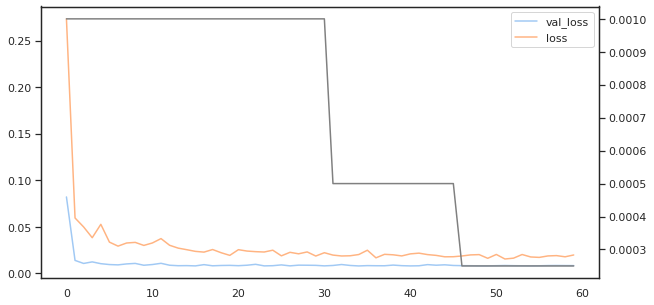

In [38]:
plot_train_results(history)

In [39]:
y_train_pred, y_val_pred, y_test_pred = predict(lstm_model, X_train, X_val, X_test)

1/1 [==============================] - 0s 32ms/step


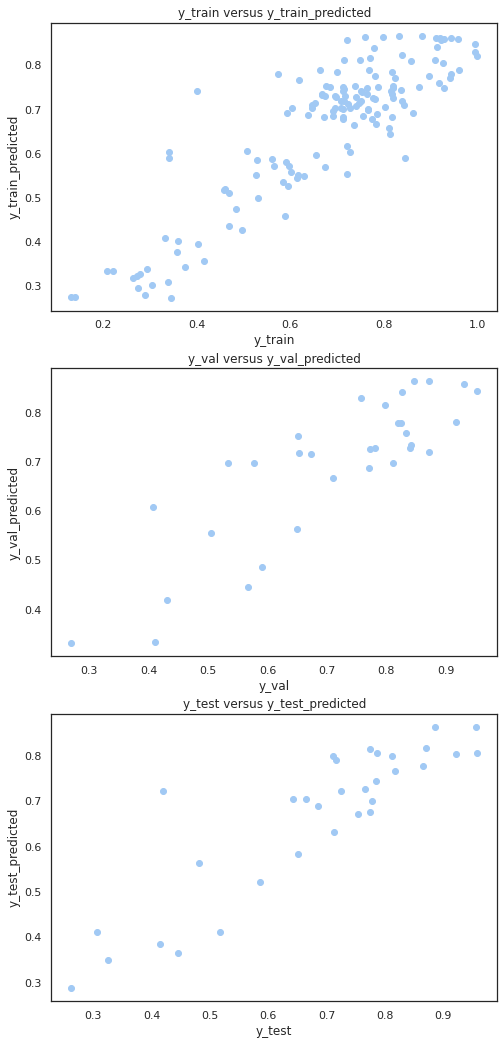

In [40]:
plot_predictions_scatter(y_train, y_train_pred,
                         y_val, y_val_pred,
                         y_test, y_test_pred)

In [45]:
metricas_erro = calcular_metricas_erro(y_train, y_train_pred, 
                                       y_val, y_val_pred,
                                       y_test, y_test_pred,
                                       SLIDING_WINDOW_SIZE)
imprimir_metricas_erro(metricas_erro)

|     Métrica de Erro |  Train |    Val |   Test |
|                 MSE |  0.01% |  0.01% |  0.01% |
|                RMSE |  0.09% |  0.09% |  0.09% |
|                MAPE | 40.06% | 30.03% | 35.81% |
|            R2 Score |  0.77% |  0.71% |  0.78% |
| R2 Score (ajustado) |  0.72% | -0.28% |  0.02% |


In [46]:
# FIXME: Depois remover da série original os dados considerados anômalos identificados
#        no processo estatístico, treinar uma nova rede LSTM com os hiperparâmetros
#        escolhidos e verificar se o novo modelo é capaz de identificar (errar a
#        previsão) relativa aos dados anômalos.